<a href="https://colab.research.google.com/github/f1shstyxx/DS_capstone/blob/main/Project_2_Machine_Learning_Modeling/project_2_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2 (Part 2) - Multiclass Classification for Detection of IoT Botnet Attacks N-BaIoT

## Selection of dataset
Chose the Detection of IoT Botnet Attacks N-BaIoT from the UCI Machine Learning Repository:

https://archive.ics.uci.edu/dataset/442/detection+of+iot+botnet+attacks+n+baiot

It is a collection of CSV files per device, each representing benign and attack traffic captured from IoT devices. There is a folder for each device. Inside each are many csv files. Each CSV contains raw feature vectors extracted from traffic windows.

# Business Understanding

## Background
A botnet is a network of internet-connected devices (like computers, phones, IoT gadgets) that have been infected with malware and are being controlled remotely by an attacker, often without the owner's knowledge.

Bot = infected device ('robot')
Net = network
botnet = a network of infected devices working together

Botnets are used for:
DDoS attacks - they flood a website until it crashes
spam campaigns - send millions of phishing emails
data theft/keylogging - steal login credentials
crypto mining - use your device to mine crypto
click fraud - fake ad clicks for revenue
spreading malware - infect other systems

How botnets work:
1. Malware infects a device (eg. via phishing, weak passowrds, open ports)
2. device becomes a "zombie" - quietly waits for commands
3. all zombie devices are controlled by a command and control (C&C) server
4. attacker sends order to launch attacks or harvest data

IoT botnets increasingly target smart devices such as doorbells, cameras, thermostats, and baby monitors, because they often have poor security, making them easy targets.

## Dataset Details
What is the N-BaIoT dataset?
It’s a benchmark dataset created by researchers to help build and evaluate machine learning models for detecting botnet attacks on Internet of Things (IoT) devices.

Key facts:
1. Contains data from 9 IoT devices (eg. doorbell, camera, baby monitor)
2. The dataset contains traffic types, including benign and multiple botnet attack types (eg. Mirai, Bashlite)
3. Files are CSVs per device, each representing one type of behavior
4. Features are pre-extracted statistical features from raw network traffic
5. No "Label" columns, but filesnames will indicate if its benign or an attack

Purpose of dataset:
To support network-based intrusion detection systems that:
1. monitor traffic from IoT devices
2. detect abnormal patterns linked to botnet activity
3. work without needing deep packet inspection (for speed and privacy)

## Project goals
1. train a binary classifier to detect whether an IoT event is benign or attack
2.**This notebook trains a multi-class classification to identify specific botnet families**

## Project Considerations
1. labeling - no "label" column but file names will indicate benign or attack type
2. the data is highly imbalanced. 92% of the data is labeled as attack type, while only 8% is labeled as benign. This is now a severely imbalanced classification problem which can cause models to always predict "attack", and may lead to high accuracy but poor recall on minority class (benign)



# Data Understanding

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import time
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import randint

from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_validate,
    RandomizedSearchCV, cross_val_score
)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder,
    FunctionTransformer, LabelEncoder, label_binarize
)
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    classification_report
)

from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
# define function to load data

def load_n_baiot_data(device_dir):
    # create empty dataframes list
    dataframes = []

    # walk through the directory structure
    for root, dirs, files in os.walk(device_dir):
        for f in files:
            # look for csv files
            if f.endswith('.csv'):
                path = os.path.join(root, f)

                # Classify label based on folder + filename
                if 'benign' in f.lower():
                    label = 'benign'
                else:
                    # use folder name and file name to construct label
                    folder = os.path.basename(root).lower()
                    attack_type = os.path.splitext(f)[0].lower()
                    if 'mirai' in folder:
                        label = f'mirai_{attack_type}'
                    elif 'gafgyt' in folder:
                        label = f'gafgyt_{attack_type}'
                    else:
                        label = f'unknown_{attack_type}'

                print(f"Loading: {path} as {label}")

                try:
                    df = pd.read_csv(path, header=0)
                    df['label'] = label
                    df['source_file'] = f
                    dataframes.append(df)
                except Exception as e:
                    print(f"Error reading {path}: {e}")

    return pd.concat(dataframes, ignore_index=True)

# Parallelized version of loading all devices to speed up data loading
def load_all_devices(base_dir):
    device_paths = [
        (device_name, os.path.join(base_dir, device_name))
        for device_name in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, device_name))
    ]

    def load_device(device_info):
        device_name, device_path = device_info
        print(f"Loading: {device_name}")
        df = load_n_baiot_data(device_path)
        df['device'] = device_name
        return df

    # threadpoolexecutor allows for multiple function calls to be run asynchronously using threads
    with ThreadPoolExecutor() as executor:
        all_dfs = list(executor.map(load_device, device_paths))

    return pd.concat(all_dfs, ignore_index=True)

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# define the folder where the data is stored

# time the loading of data
start_load = time.time()

# path for data on PC
# base_dir = r"C:\Users\jtlee\Documents\Flatiron\data\detection of iot botnet attacks n baiot"

# path for data in google drive
base_dir = r'/content/drive/MyDrive/detection of iot botnet attacks n baiot'

# load all devices data
full_df = load_all_devices(base_dir)

# end of data loading
end_load = time.time()
print(f"Loading time: {(end_load - start_load) / 60:.2f} minutes")

# data loading took 1.59 min on 7/19/25

Loading: Samsung_SNH_1011_N_Webcam
Loading: /content/drive/MyDrive/detection of iot botnet attacks n baiot/Samsung_SNH_1011_N_Webcam/benign_traffic.csv as benign
Loading: Provision_PT_838_Security_Camera
Loading: SimpleHome_XCS7_1002_WHT_Security_Camera
Loading: /content/drive/MyDrive/detection of iot botnet attacks n baiot/Provision_PT_838_Security_Camera/benign_traffic.csv as benign
Loading: /content/drive/MyDrive/detection of iot botnet attacks n baiot/SimpleHome_XCS7_1002_WHT_Security_Camera/benign_traffic.csv as benign
Loading: Danmini_Doorbell
Loading: SimpleHome_XCS7_1003_WHT_Security_Camera
Loading: /content/drive/MyDrive/detection of iot botnet attacks n baiot/Danmini_Doorbell/benign_traffic.csv as benign
Loading: Philips_B120N10_Baby_Monitor
Loading: Provision_PT_737E_Security_Camera
Loading: /content/drive/MyDrive/detection of iot botnet attacks n baiot/SimpleHome_XCS7_1003_WHT_Security_Camera/benign_traffic.csv as benign
Loading: Ennio_Doorbell
Loading: /content/drive/MyDri

In [ ]:
full_df['label'].value_counts()

,count
label,
mirai_udp,1229999
gafgyt_udp,946366
gafgyt_tcp,859850
mirai_syn,733299
mirai_ack,643821
benign,555932
mirai_scan,537979
mirai_udpplain,523304
gafgyt_combo,515156


In [ ]:
# Desired sample sizes for each label (class)
target_sizes = {
    'benign': 50_000,
    'mirai_udp': 50_000,
    'gafgyt_udp': 50_000,
    'gafgyt_tcp': 50_000,
    'mirai_syn': 50_000,
    'mirai_ack': 50_000,
    'mirai_scan': 50_000,
    'mirai_udpplain': 50_000,
    'gafgyt_combo': 50_000,
    'gafgyt_junk': 50_000,
    'gafgyt_scan': 50_000,
}

# initialize empty dataframes to downsize the data for each label
dfs = []

for label, n in target_sizes.items():
    subset = full_df[full_df['label'] == label]
    sampled = subset.sample(n=min(n, len(subset)), random_state=42)
    dfs.append(sampled)

# combine downsampled dataframes of each label into 1
downsampled_df = pd.concat(dfs, ignore_index=True)

# Confirm class balance
print(downsampled_df['label'].value_counts())

downsampled_df = downsampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

label
benign            50000
mirai_udp         50000
gafgyt_udp        50000
gafgyt_tcp        50000
mirai_syn         50000
mirai_ack         50000
mirai_scan        50000
mirai_udpplain    50000
gafgyt_combo      50000
gafgyt_junk       50000
gafgyt_scan       50000
Name: count, dtype: int64


In [ ]:
downsampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550000 entries, 0 to 549999
Columns: 118 entries, MI_dir_L5_weight to device
dtypes: float64(115), object(3)
memory usage: 495.1+ MB


In [ ]:
# examine df characteristics
print("Device dataframe shape:\n", downsampled_df.shape)
print("\nDevice dataframe - # of observations:\n", downsampled_df['device'].value_counts())
print("\nDevice dataframe - # of types of observations:\n", downsampled_df['label'].value_counts())

Device dataframe shape:
 (550000, 118)

Device dataframe - # of observations:
 device
Philips_B120N10_Baby_Monitor                84363
Danmini_Doorbell                            76122
SimpleHome_XCS7_1002_WHT_Security_Camera    66260
Provision_PT_838_Security_Camera            65343
Provision_PT_737E_Security_Camera           64864
SimpleHome_XCS7_1003_WHT_Security_Camera    64606
Ecobee_Thermostat                           63958
Samsung_SNH_1011_N_Webcam                   32842
Ennio_Doorbell                              31642
Name: count, dtype: int64

Device dataframe - # of types of observations:
 label
gafgyt_junk       50000
mirai_udp         50000
mirai_ack         50000
gafgyt_udp        50000
mirai_syn         50000
benign            50000
gafgyt_tcp        50000
mirai_scan        50000
gafgyt_scan       50000
mirai_udpplain    50000
gafgyt_combo      50000
Name: count, dtype: int64


Data is highly imbalanced in the original dataset, and is designed to be imbalanced in downsampled_df, to mirror the original dataset with an overall ratio of 1:11 of benign to attack data.

Will need to use stratified splits during train_test_split. And class weights in models like lrandom forest and XGBoost

Cannot rely on accuracy metric since this is an imbalanced multiclass classification. If one class dominates, the model can predict that class all the time and still get high accuracy, while failing to detect attacks.

Will need to use precision, recall, f1-score, ROC-AUC, and confusion matrix

In [ ]:
print("\nDevice dataframe - preview:\n", downsampled_df.head())


Device dataframe - preview:
    MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0        155.358927       74.178981           27.600159        260.768255   
1        108.870716      535.362978         8678.057894        191.489309   
2        185.371979      231.092680        57300.189637        269.037094   
3        162.092535       74.138910            3.315486        250.603852   
4          1.000000       60.000000            0.000000          1.000000   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0       74.310489           63.644526        757.541254       74.523436   
1      509.523664        19742.498541        629.066109      457.130983   
2      282.027040        63049.621376        685.626850      350.713429   
3       74.102060            2.470587        537.402789       74.090315   
4       60.000000            0.000000          1.000000       60.000000   

   MI_dir_L1_variance  MI_dir_L0.1_weight  ...  HpHp_L0.

In [ ]:
# check for missing values
missing_values = downsampled_df.isnull().sum()[downsampled_df.isnull().sum() > 0]
print(f"\nMissing values in each column:\n{missing_values}")


Missing values in each column:
Series([], dtype: int64)


There are no missing values in any feature columns

In [ ]:
# basic statistical summary
numeric_features = downsampled_df.select_dtypes(include = ['int64', 'float64']).columns.tolist()

print(f"Numerical feature statistics:\n{downsampled_df[numeric_features].describe()}")

Numerical feature statistics:
       MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count     550000.000000   550000.000000       550000.000000     550000.000000   
mean          86.796360      159.051321        12748.197547        136.921945   
std           68.512592      154.179951        22902.092423        109.553269   
min            1.000000       60.000000            0.000000          1.000000   
25%            2.494513       60.003196            0.000007          2.926574   
50%           93.465247       74.026631            3.129148        141.348741   
75%          148.424839      239.891585        17148.620789        238.344259   
max          434.164516     1452.551907       491752.379500        547.479375   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count   550000.000000       550000.000000     550000.000000   550000.000000   
mean       159.163763        14142.381109        386.000701      159.412487   
std

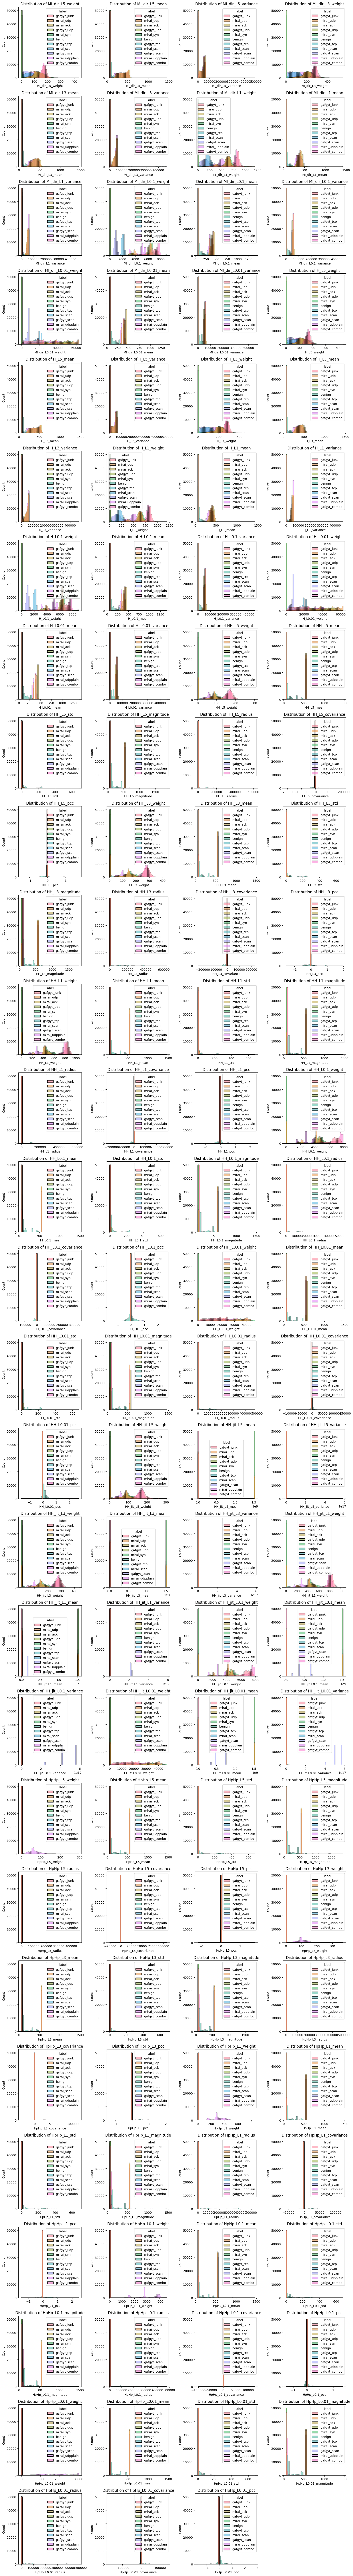

Plotting time: 3.08 minutes


In [ ]:
# examine distribution of each numeric feature

# time plotting of features
start_plot = time.time()

# determine size of plot based on number of features
n = len(numeric_features)
rows = int(np.ceil(n / 4))
plt.figure(figsize=(16, 4 * rows))

# plot histograms of numerical features

sample_df = downsampled_df

for i, feature in enumerate(numeric_features):
    plt.subplot(rows, 4, i+1)
    sns.histplot(data = sample_df, x=feature, hue='label', kde=False, bins=50)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

end_plot = time.time()

print(f"Plotting time: {(end_plot - start_plot) / 60:.2f} minutes")

# Plotting took 3 min on 7/19/25

# Data Preparation

In [ ]:
# split data into features and target

X = downsampled_df.drop(columns=['label', 'source_file', 'device'], errors='ignore')

y = downsampled_df['label']

le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [ ]:
# split into training and test sets (80% train, 20% test), use random_state=42 and set stratify = y
# random_state=42 ensures reproducibility
# stratify y to preserve class balance

X_train, X_test, y_encoded_train, y_encoded_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Random forest pipeline
# random_state=42 for reproducibility
# class weight = 'balanced' to adjust for class imbalance (benign = 8%)
# n_jobs=-1 to use all available cores for parallel processing

rf_pipeline = Pipeline(steps = [
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

# Modeling

In [ ]:
# define parameter search for random search

# Define multiple scoring metrics
scoring = {
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

# define parameter distributions for random forest
rf_param_distr = {
    'classifier__max_depth': randint(5, 20),  # max depth of trees
    'classifier__min_samples_split': randint(2, 15),  # min samples to split a node
    'classifier__min_samples_leaf': randint(2, 10),  # min samples at a leaf node
    'classifier__n_estimators': randint(30, 100),  # number of trees in the forest
    'classifier__class_weight': ['balanced'],  # class weights
    'classifier__bootstrap': [True]
}

# use random search to get a ballpark estimate of the best parameters
rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_distr,
    n_iter=15,  # number of random combinations to try
    cv=5,  # 5-fold cross-validation
    scoring=scoring,
    refit='f1',  # refit the model based on f1, FP and FN are equally costly
    return_train_score=True,
    random_state=42,    # to ensure reproducibility
    n_jobs=-1,  # use all available cores
    verbose=1  # show progress
)

In [ ]:
# time random forest
start_rf = time.time()

# fit the model
rf_random_search.fit(X_train, y_encoded_train)

end_rf = time.time()
print(f"Random Forest fitting time: {(end_rf - start_rf) / 60:.2f} minutes")

# Random Forest fitting time: 22.82 min on 7/18/25 w/ 5 folds, 15 candidates
# RF fitting time 26.83 min on 7/19/25

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Random Forest fitting time: 26.83 minutes


In [ ]:
print("\nBest random forest parameters:\n")
print(rf_random_search.best_params_)


Best random forest parameters:

{'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 11, 'classifier__n_estimators': 89}


In [ ]:
# optimization of hyperparameters

# define parameter grid for random forest
rf_param_grid = {
    'classifier__n_estimators': [85, 90, 95],
    'classifier__max_depth': [14, 15, 16],
    'classifier__min_samples_split': [10, 11, 12],
    'classifier__min_samples_leaf': [3, 4, 5],
    'classifier__class_weight': ['balanced']
}

# define scoring
scoring = {
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

In [ ]:
# perform grid search for random forest

# time random forest grid search
start = time.time()

# create grid search object for random forest
rf_grid_search = GridSearchCV(
    rf_pipeline,
    param_grid = rf_param_grid,
    cv=3,   # cut down cv to 3 to save on grid search time
    scoring=scoring,
    refit='f1',
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

# fit the random forest grid search
rf_grid_search.fit(X_train, y_encoded_train)

end = time.time()
print(f"Random Forest grid search time: {(end - start) / 60:.2f} minutes")

# Random Forest grid search time: 102 min on 7/19/25

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Random Forest grid search time: 102.46 minutes


In [ ]:
# boosting models

start = time.time()

# XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_encoded_train)

# get training scores
xgb_train_score = xgb_model.score(X_train, y_encoded_train)

# Cross validate all models using accuracy (don't average the scores)
xgb_cv_scores = cross_val_score(xgb_model, X_train, y_encoded_train, cv=5, scoring='f1_weighted')

end = time.time()
print(f"XGBoost fitting time: {(end - start) / 60:.2f} minutes")

# XGBoost fitting time: 4 min on 7/18/25
# XGBoost fitting time: 3.3 min on 7/19/25

XGBoost fitting time: 3.31 minutes


In [ ]:
print(f"Training and Cross Validation Performance Comparison of XGBoost Model")
print(f"Extreme Gradient Boosting: Train - {xgb_train_score:.3f}, CV - {xgb_cv_scores.mean():.3f}")

Training and Cross Validation Performance Comparison of XGBoost Model
Extreme Gradient Boosting: Train - 0.998, CV - 0.998


Training and Cross validation F1 scores are identical, meaning there is no overfitting. The model performs equally well on training and unseen cross-validation folds. The model generalizes well and its not just memorizing patterns learn in training.

In [ ]:
# XGBoost hyperparameter tuning

start = time.time()

xgb_grid_search = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Create Param Grid
param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [200, 300],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'scale_pos_weight': [1, 3]
}

# Instantiate GridSearchCV object
grid_search = GridSearchCV(
    xgb_grid_search,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

grid_search.fit(X_train, y_encoded_train)

end = time.time()
print(f"XGBoost grid search time: {(end - start) / 60:.2f} minutes")

# XGBoost grid search time: 157 min on 7/19/25

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost grid search time: 157.28 minutes


# Evaluation

In [ ]:
# Evaluate function

def evaluate_model(name, model, X_test, y_test, label_encoder):
    # Predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Compute metrics
    metrics = {
        'Model': name,
        'Precision': precision_score(y_encoded_test, y_pred, average='weighted'),
        'Recall': recall_score(y_encoded_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_encoded_test, y_pred, average='weighted'),
        'ROC AUC': roc_auc_score(
            y_encoded_test,
            y_proba,
            multi_class='ovr',  # one-vs-rest is generally more stable
            average='weighted'
        ) if y_proba is not None and len(np.unique(y_encoded_test)) > 2 else np.nan
    }

    # Confusion Matrix
    cm = confusion_matrix(y_encoded_test, y_pred)
    class_labels = label_encoder.classes_

    print(f"\n{name} Confusion Matrix:\n", cm)
    ConfusionMatrixDisplay(cm, display_labels=class_labels).plot(xticks_rotation=45)
    plt.title(f"{name} - Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return metrics


Random Forest Confusion Matrix:
 [[10000     0     0     0     0     0     0     0     0     0     0]
 [    1  9998     1     0     0     0     0     0     0     0     0]
 [    3     2  9995     0     0     0     0     0     0     0     0]
 [    4     0     0  9996     0     0     0     0     0     0     0]
 [    1     1     0     0  9761   237     0     0     0     0     0]
 [    9     0     0     0     0  9991     0     0     0     0     0]
 [    1     0     0     0     0     0  9999     0     0     0     0]
 [    0     0     0     2     1     0     0  9997     0     0     0]
 [    0     0     0     0     0     0     0     0 10000     0     0]
 [    0     0     0     0     0     0     0     1     0  9998     1]
 [    0     0     0     0     0     0     0     0     0     0 10000]]


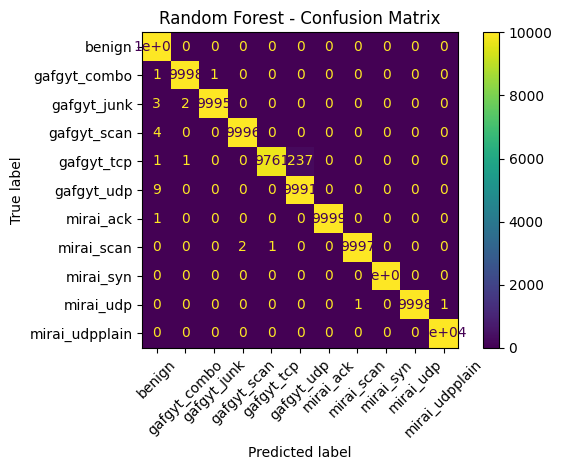


XGBoost Confusion Matrix:
 [[10000     0     0     0     0     0     0     0     0     0     0]
 [    0  9999     1     0     0     0     0     0     0     0     0]
 [    0     2  9998     0     0     0     0     0     0     0     0]
 [    0     0     1  9999     0     0     0     0     0     0     0]
 [    0     0     0     0  9763   236     0     0     0     1     0]
 [    1     0     0     0     2  9997     0     0     0     0     0]
 [    0     0     0     0     0     0  9999     0     0     0     1]
 [    0     0     0     0     0     0     0 10000     0     0     0]
 [    0     0     0     0     0     0     0     0 10000     0     0]
 [    0     0     0     0     0     0     0     0     0 10000     0]
 [    0     0     0     0     0     0     0     0     0     0 10000]]


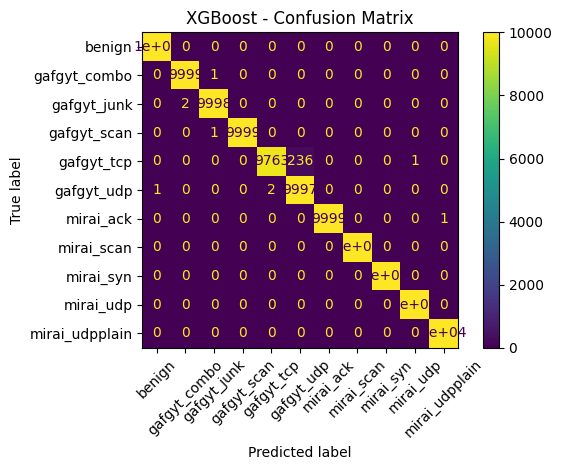

,Precision,Recall,F1 Score,ROC AUC
Model,,,,
Random Forest,0.997639,0.997591,0.997590,0.999785
XGBoost,0.997821,0.997773,0.997772,0.999787


In [ ]:
# Best XGB and random forest models after tuning
rf_best_model = rf_grid_search.best_estimator_

# Already trained XGB model (can replace with best estimator from grid_search if needed)
xgb_best_model = grid_search.best_estimator_

# Evaluate best models
rf_metrics = evaluate_model("Random Forest", rf_grid_search.best_estimator_, X_test, y_encoded_test, le)
xgb_metrics = evaluate_model("XGBoost", grid_search.best_estimator_, X_test, y_encoded_test, le)

# Combine into a DataFrame for comparison
results_df = pd.DataFrame([rf_metrics, xgb_metrics])
results_df = results_df.set_index('Model')
display(results_df)

Most classes have correctly classified samples out of 10,000. There are only minor off-diagonal values with 1-3 samples misclassified. The only noticeable confusion is between gafgyt_tcp and gafgyt_udp

In [ ]:
# assess for overfitting for RF

# --- Random Forest ---

# Training F1
rf_train_f1 = f1_score(y_encoded_train, rf_best_model.predict(X_train), average='weighted')

# Cross-Validation F1
rf_cv_f1 = cross_val_score(rf_best_model, X_train, y_encoded_train, cv=5, scoring='f1_weighted').mean()

# Test F1
rf_test_f1 = f1_score(y_encoded_test, rf_best_model.predict(X_test), average='weighted')

print(f"Random Forest F1 Score:\nTrain: {rf_train_f1:.4f}, CV: {rf_cv_f1:.4f}, Test: {rf_test_f1:.4f}")

Random Forest F1 Score:
Train: 0.9978, CV: 0.9977, Test: 0.9976


Train, CV, and test f1 scores are identical, meaning the model is very stable and there is no sign of overfitting or underfitting. The models are generalized very well. This level of performance means the data is very separable and the features are highly predictive

In [ ]:
# assess for overfitting for XGBoost

# Training performance
xgb_train_f1 = f1_score(y_encoded_train, xgb_best_model.predict(X_train), average='weighted')

# Cross-validation performance (already done)
xgb_cv_f1 = cross_val_score(xgb_best_model, X_train, y_encoded_train, cv=5, scoring='f1_weighted').mean()

# Test set performance
xgb_test_f1 = f1_score(y_encoded_test, xgb_best_model.predict(X_test), average='weighted')

print(f"\nXGBoost F1 Score:\nTrain: {xgb_train_f1:.4f}, CV: {xgb_cv_f1:.4f}, Test: {xgb_test_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:50:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:52:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:53:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:55:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:56:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weigh


XGBoost F1 Score:
Train: 0.9979, CV: 0.9978, Test: 0.9978


The model perfectly classifies both classes, even on unseen data. There is no indication of overfitting as CV and test performance match training performance. XGBoost is learning meaningful patterns, not memorizing training data.

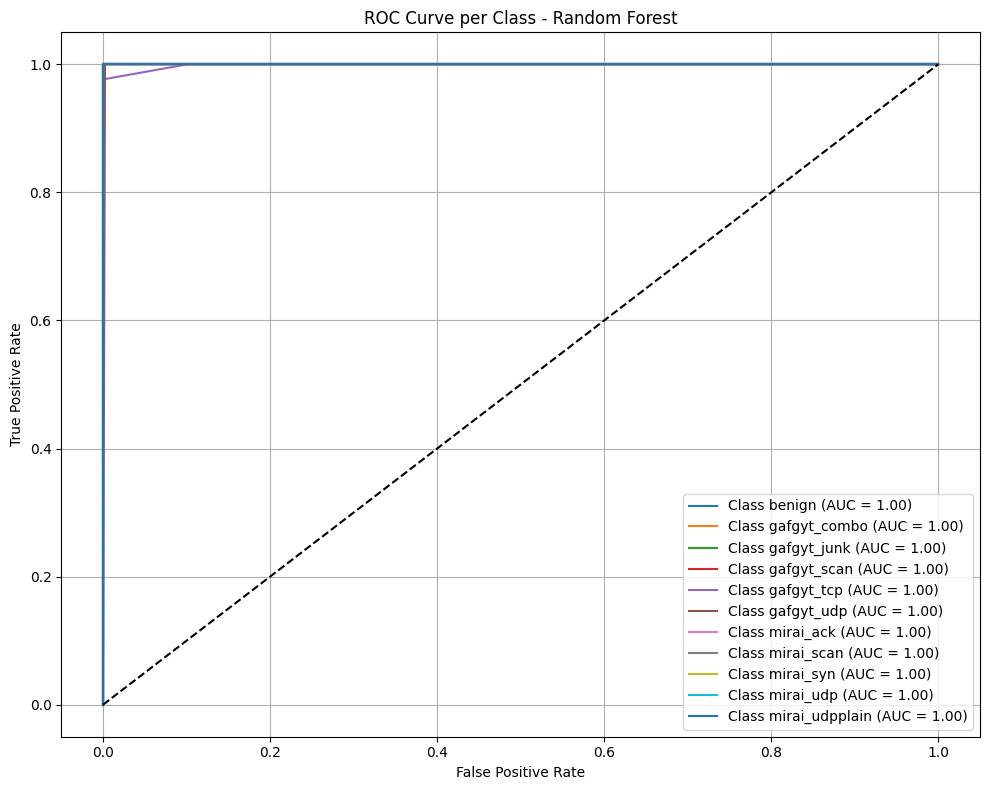

In [ ]:
# Binarize the output
y_test_bin = label_binarize(y_encoded_test, classes=np.unique(y_encoded))
n_classes = y_test_bin.shape[1]

# Get probabilities per class for RF
rf_probs = rf_best_model.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], rf_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {le.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

All AUCs = 1.0, meaning there is perfect class separation for each botnet type. The curves all mostly hug the top-left corner meaning the classifier has near-zero false positives and maximum true positives. The black dashed line represents random guessing and the model is far above that for every class.

The Random Forest model confidently distinguishes each attack type. The model is highly effective at detecting diverse IoT botnet traffic.

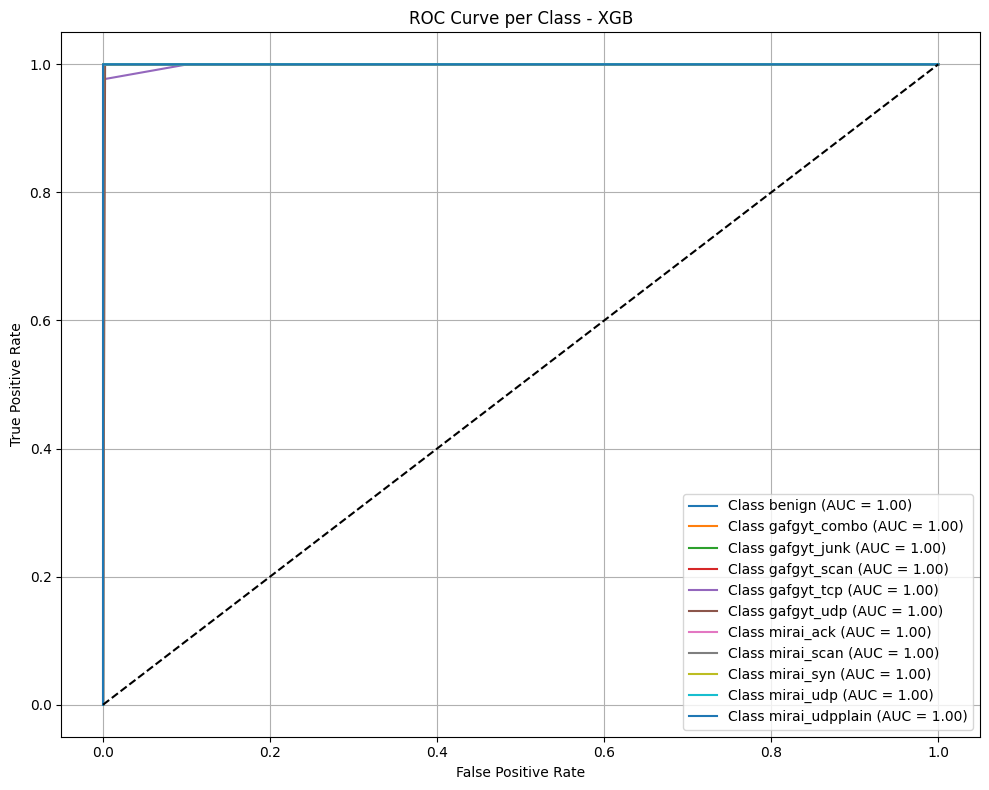

In [ ]:
# get probabilities for XGB
xgb_probs = xgb_best_model.predict_proba(X_test)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], xgb_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {le.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class - XGB')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

All AUCs = 1.0, meaning there is perfect class separation for each botnet type. The curves all mostly hug the top-left corner meaning the classifier has near-zero false positives and maximum true positives. The black dashed line represents random guessing and the model is far above that for every class.

The XGBoost model confidently distinguishes each attack type. The model is highly effective at detecting diverse IoT botnet traffic.

In [ ]:
# select best model based on F1 score
# use F1 score because both false positive and false negatives are costly
# false positive (flagging benign as attack) may overload response systems
# false negatives (flagging attack as benign) are security risks
best_model_name = results_df['F1 Score'].idxmax()

model_map = {
    'Random Forest': rf_grid_search.best_estimator_,
    'XGBoost': grid_search.best_estimator_
}

best_model = model_map[best_model_name]

print(f"Best model based on F1 Score: {best_model_name}")
display(results_df.sort_values(by="F1 Score", ascending=False))

Best model based on F1 Score: XGBoost


,Precision,Recall,F1 Score,ROC AUC
Model,,,,
XGBoost,0.997821,0.997773,0.997772,0.999787
Random Forest,0.997639,0.997591,0.997590,0.999785


Both models are performing extremely well. XGBoost has a slight edge in F1 score, precision, recall, and ROC-AUC, making it the best choice when the priority is minimizing false positives and false negatives.

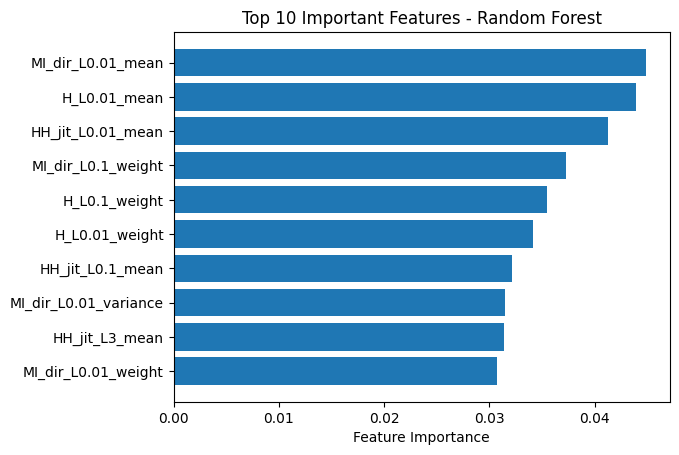

In [ ]:
# importances of features for random forest
rf_importances = rf_best_model.named_steps['classifier'].feature_importances_
feature_names = X_train.columns
sorted_idx = np.argsort(rf_importances)[::-1][:10]
plt.barh(range(len(sorted_idx)), rf_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features - Random Forest")
plt.gca().invert_yaxis()
plt.show()

Mutual Information (MI) and Entropy (H) dominate as the most important features. They are essential for traffic pattern analysis in botnet detection.

FEatures for early lag windows (L0.01, L0.1) are most influential as botnet behavior likely leaves strong signatures early in flows.

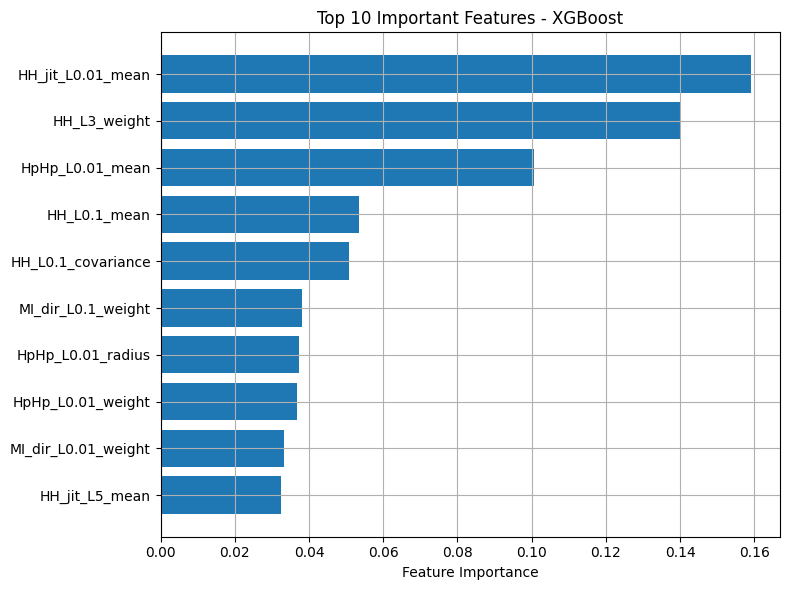

In [ ]:
# importances of features for XGBoost

# Extract feature importances from classifier step in pipeline
xgb_importances = xgb_best_model.feature_importances_

# Get feature names from training data
feature_names = X_train.columns

# Get indices of top 10 important features
sorted_idx = np.argsort(xgb_importances)[::-1][:10]

# Plot
plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), xgb_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features - XGBoost")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


The XGBoost model shows a different perspective than Random Forest. It emphasizes different dynamics in the traffic data.

XGBoost emphasizes jitter and hop-level entropy more than Random Forest. it focuses on fine-trained network signal variance, indicating sensitivity to subtle traffic behavior shifts.

In [ ]:
# save models to google drive
import joblib

joblib.dump(rf_best_model, '/content/drive/MyDrive/rf_best_model.pkl')
joblib.dump(xgb_best_model, '/content/drive/MyDrive/xgb_best_model.pkl')

# To load:
# rf_best_model = joblib.load('/content/drive/MyDrive/rf_best_model.pkl')
# xgb_best_model = joblib.load('/content/drive/MyDrive/xgb_best_model.pkl')

['/content/drive/MyDrive/xgb_best_model.pkl']

# Conclusion

The XGBoost model demonstrated remarkable accuracy across all botnet attack classes and benign traffic, as shown in the confusion matrix. Misclassifications were minimal and generally occurred between similar attack variants such as gafgyt_combo and gafgyt_junk, or gafgyt_tcp vs. gafgyt_udp. This indicates that the model is highly effective at distinguishing between sophisticated botnet behaviors in IoT traffic.

Business value:
The business value of this model means that it can improve network security, providing early and accurate detection of botnet traffic before devices are compromised. It can also predict what kind of attack, giving this model a leg up on the previous models which only predict benign vs a general attack type. It provides faster incident response so that security can act quickly and confidently. It allows for lower operational cost, as false alerts are minimized reducing alert fatigue and unnecessary investigations.

Actionable recommendations:
The XGboost model should be deployed and used to flag and block suspicious traffic in real time.
Priority should be given to monitoring features like jitter and hop-level entropy describing traffic data dynamics.
The model should continue to be trained periodically with new traffic data to ensure detection of evolving traffic patterns.

Implementation considerations and limitations:
IoT traffic patterns may evolve so regular updates of the model are required.
If attackers find out about the model, they might adapt their behavior to mimic benign patterns.
When it comes time to deploy the model in an IoT environment, it should be be a low-latency, low-memory, and offline-capable deployment. The model would have to be trained and saved, and then exported by cross-compling the XGBoost model for the IoT device and then deployed to the device.